In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
data_path = "../../data/image-data/output/one-class_syn2_size-color-diff-2D/images-config.tsv"
df = pd.read_csv(data_path, sep="\t", header=None)
df['features'] = df[4].map(lambda x:[float(i.split("=")[-1]) for i in x.split()])
df['f1'] = df['features'].map(lambda x:x[0])
df['f2'] = df['features'].map(lambda x:x[1])

In [3]:
x_w = df[['f1', 'f2']].loc[:99].values
x_v = df[['f1', 'f2']].loc[100:].values
x = np.vstack([x_w, x_v])

X_train_w = x_w[:80]
X_train_v = x_v[:80]
X_test_w = x_w[80:]
X_test_v = x_v[80:]

X_train = np.vstack([X_train_w, X_train_v])
X_test = np.vstack([X_test_w, X_test_v])
y_train = np.hstack([np.zeros(80), np.ones(80)]).astype(int)
y_test = np.hstack([np.zeros(20), np.ones(20)]).astype(int)

(0.0, 1.0)

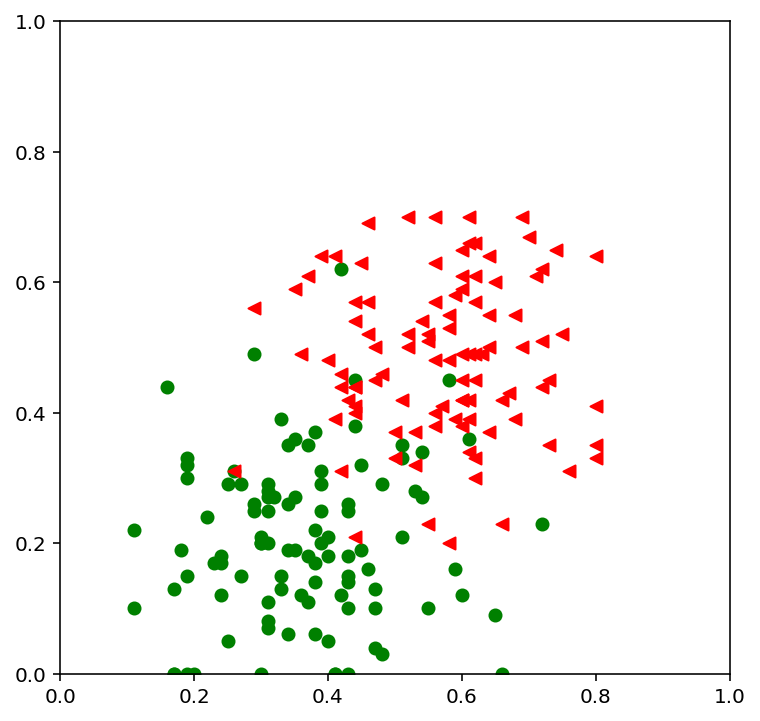

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_w[:,0], x_w[:,1], c='g', marker='o')
ax.scatter(x_v[:,0], x_v[:,1], c='r', marker='<')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [5]:
def param2hyp(orientation, intercept):
    w1, w2 = np.tan(orientation), -1
    b = intercept
    return np.array([w1, w2, b])

def add_bias(x):
    return np.hstack([x, np.ones([x.shape[0], 1])])

In [6]:
np.random.seed(42)
params = []
for i in range(8):
    means = [np.pi / 4 * i, 0]
    covs = [[2, 0], [0, .005]]
    for j in range(12):
        param = np.random.multivariate_normal(means, covs)
        params.append(param)
params = np.vstack(params)
simple_hyps = np.vstack(list(map(lambda x: param2hyp(*x), params)))

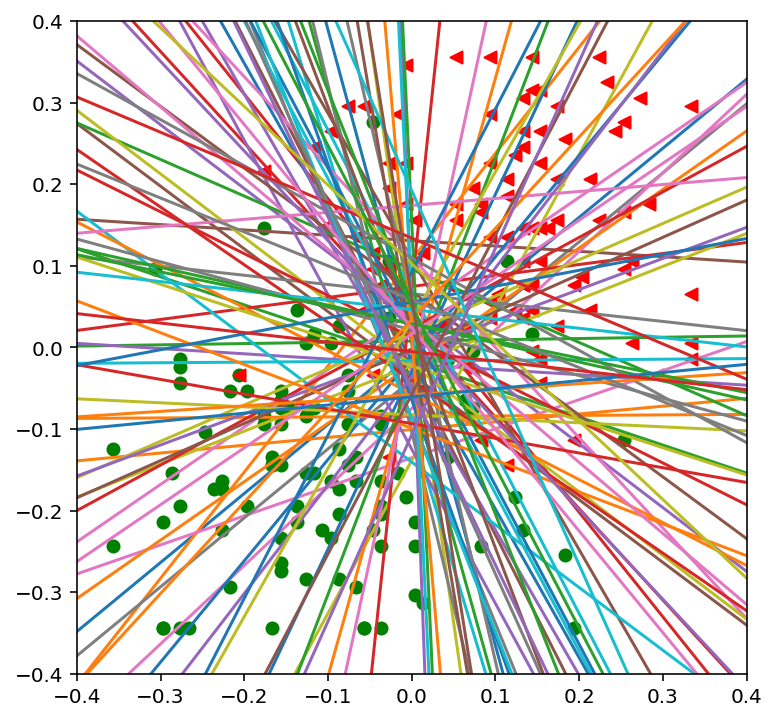

In [7]:
x_w_norm = x_w - x.mean(0)
x_v_norm = x_v - x.mean(0)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_w_norm[:,0], x_w_norm[:,1], c='g', marker='o')
ax.scatter(x_v_norm[:,0], x_v_norm[:,1], c='r', marker='<')
ax.set_xlim([-.4, .4])
ax.set_ylim([-.4, .4])
x_lin = np.linspace(-.4, .4)
for i in range(len(params)):
    h = params[i]
    ax.plot(x_lin, x_lin * np.tan(h[0]) + h[1])
# h = simple_hyps[0]
# pos_w = np.where(add_bias(x_w_norm) @ h > 0)
# pos_v = np.where(add_bias(x_v_norm) @ h > 0)
# ax.scatter(x_w_norm[pos_w,0], x_w_norm[pos_w,1], c='y', marker='+')
# ax.scatter(x_v_norm[pos_v,0], x_v_norm[pos_v,1], c='y', marker='+')
# ax.plot(x_lin, x_lin * np.tan(h[0]) + h[1])
# ax.grid()

In [44]:
import numpy as np
from scipy.stats import entropy
from collections import defaultdict


def user_model(w, x, y, alpha):
    # multi-class user model - w is CxD and X is NxD
    # prob is probability that the hyp agrees with the datapoint
    z = alpha*np.dot(x, w.T)
    pred_class = np.argmax(z,1)
    z_norm = np.exp(z) / np.exp(z).sum(1)[..., np.newaxis]

    prob = z_norm[np.arange(x.shape[0]), pred_class]  # pred_class == y
    inds = np.where(pred_class != y)[0]
    prob[inds] = 1.0 - prob[inds]                     # pred_class != y
    return prob, pred_class


def compute_likelihood(hyps, X, Y, alpha, one_v_all=False):
    # compute P(y|h,x) - size HxN
    # is set to one where h(x) = y i.e. correct guess
    likelihood = np.ones((len(hyps), X.shape[0]))
    likelihood_opp = np.ones((len(hyps), X.shape[0]))

    for hh in range(len(hyps)):
        if one_v_all:
            # assumes that hyps[hh] is a D dim vector
            prob_agree, pred_class = user_model_binary(hyps[hh], X, Y, alpha)
        else:
            # assumes that hyps[hh] is a CxD dim maxtrix
            prob_agree, pred_class = user_model(hyps[hh], X, Y, alpha)
        inds = np.where(pred_class != Y)[0]
        likelihood[hh, inds] = prob_agree[inds]

    return likelihood


def more_teaching_stats(cur_post, pred, lnr_post, lnr_pred, err_hyp, err_hyp_test, selected_ind):

    cur_post_norm = cur_post/cur_post.sum()
    lnr_post_norm = lnr_post/lnr_post.sum()
    lnr_hyp = np.random.choice(len(lnr_post_norm), p=lnr_post_norm)
    exp_err = (cur_post_norm*err_hyp).sum()
    exp_err_test = err_hyp_test[lnr_hyp]
    ent = entropy(lnr_post_norm)

    z = (lnr_post_norm[:,np.newaxis]*pred).sum(0) + 0.0000000001  # add small noise
    # z = lnr_pred[lnr_hyp] + 0.0000000001  # add small noise
    difficulty = -(z*np.log2(z) + (1-z)*np.log2(1-z))
    diff_x = difficulty[selected_ind]
    diff_mean = np.mean(difficulty)
    diff_pctl = np.argsort(difficulty)[selected_ind] / len(difficulty)
    pred_ent = entropy(difficulty / difficulty.sum())

    stats = {
        'lnr_post_norm': lnr_post_norm,
        'lnr_hyp': lnr_hyp,
        'exp_err': exp_err,
        'exp_err_test': exp_err_test,
        'hyp_entropy': ent,
        'difficulty': diff_x,
        'diff_all': difficulty,
        'diff_mean': diff_mean,
        'diff_pctl': diff_pctl,
        'pred_ent': pred_ent,
    } 

    return stats


class StrictTeacher:

    def __init__(self, dataset, alpha, lnr_alpha, prior_h, hyps):
        X, Y = dataset['X'], dataset['Y']
        self.teaching_exs = []
        self.unseen_exs = np.arange(X.shape[0])
        self.hyps = hyps
        self.prior_h = prior_h
        self.cur_post = prior_h.copy()
        self.alpha = alpha
        self.pred = np.zeros((len(hyps), len(X)))
        self.likelihood = compute_likelihood(hyps, X, Y, alpha)
        self.lnr_post = prior_h.copy()
        self.lnr_alpha = lnr_alpha
        self.lnr_pred = np.zeros((len(hyps), len(X)))
        self.lnr_likelihood = compute_likelihood(hyps, X, Y, lnr_alpha)
        for hh in range(len(hyps)):
            for xx in range(len(X)):
                self.pred[hh, xx], _ = user_model(hyps[hh], X[xx,:][np.newaxis, ...], Y[xx], self.alpha)
                self.lnr_pred[hh, xx], _ = user_model(hyps[hh], X[xx,:][np.newaxis, ...], Y[xx], self.lnr_alpha)
        self.stats = defaultdict(list)

    def run_teaching(self, num_teaching_itrs, dataset, hyps, err_hyp, err_hyp_test):
        for tt in range(num_teaching_itrs):
            self.teaching_iteration(dataset['X'], dataset['Y'], hyps, err_hyp, err_hyp_test)

    def teaching_iteration(self, X, Y, hyps, err_hyp, err_hyp_test):

        # this is eqivalent to looping over h and x
        # comes from separating P(h|(A U x)) into P(h|A)P(h|x)
        err = -np.dot(self.cur_post*err_hyp, self.likelihood)
        selected_ind = self.unseen_exs[np.argmax(err[self.unseen_exs])]

        # update the posterior with the selected example
        self.cur_post *= self.likelihood[:, selected_ind]
        self.lnr_post *= self.lnr_likelihood[:, selected_ind]

        # bookkeeping and compute stats
        stats = more_teaching_stats(self.cur_post, self.pred, self.lnr_post, self.lnr_pred, err_hyp, err_hyp_test, selected_ind)
        self.stats['lnr_post_norm'].append(stats['lnr_post_norm'])
        self.stats['lnr_hyp'].append(stats['lnr_hyp'])
        self.stats['exp_err'].append(stats['exp_err'])
        self.stats['exp_err_test'].append(stats['exp_err_test'])
        self.stats['hyp_entropy'].append(stats['hyp_entropy'])
        self.stats['difficulty'].append(stats['difficulty'])
        self.stats['diff_all'].append(stats['diff_all'])
        self.stats['diff_mean'].append(stats['diff_mean'])
        self.stats['diff_pctl'].append(stats['diff_pctl'])
        self.stats['pred_ent'].append(stats['pred_ent'])
        self.teaching_exs.append(selected_ind)
        self.unseen_exs = np.setdiff1d(np.arange(X.shape[0]), self.teaching_exs)


class RandomImageTeacher:
    # assumes CxD hypotheses

    def __init__(self, dataset, lnr_alpha, prior_h, hyps):
        X, Y = dataset['X'], dataset['Y']
        self.teaching_exs = []
        self.hyps = hyps
        self.prior_h = prior_h
        self.lnr_post = prior_h.copy()
        self.lnr_alpha = lnr_alpha
        self.lnr_pred = np.zeros((len(hyps), len(X)))
        self.lnr_likelihood = compute_likelihood(hyps, X, Y, lnr_alpha)
        for hh in range(len(hyps)):
            for xx in range(len(X)):
                self.lnr_pred[hh, xx], _ = user_model(hyps[hh], X[xx,:][np.newaxis, ...], Y[xx], self.lnr_alpha)
        self.stats = defaultdict(list)

    def run_teaching(self, num_teaching_itrs, dataset, hyps, err_hyp, err_hyp_test):
        X = dataset['X']
        Y = dataset['Y']
        self.teaching_exs = np.random.choice(X.shape[0], num_teaching_itrs, replace=False)

        for teaching_ex in self.teaching_exs:

            self.lnr_post *= self.lnr_likelihood[:, teaching_ex]

            # bookkeeping and compute stats
            stats = more_teaching_stats(self.lnr_post, self.lnr_pred, self.lnr_post, self.lnr_pred, err_hyp, err_hyp_test, teaching_ex)
            self.stats['lnr_post_norm'].append(stats['lnr_post_norm'])
            self.stats['lnr_hyp'].append(stats['lnr_hyp'])
            self.stats['exp_err'].append(stats['exp_err'])
            self.stats['exp_err_test'].append(stats['exp_err_test'])
            self.stats['hyp_entropy'].append(stats['hyp_entropy'])
            self.stats['difficulty'].append(stats['difficulty'])
            self.stats['diff_all'].append(stats['diff_all'])
            self.stats['diff_mean'].append(stats['diff_mean'])
            self.stats['diff_pctl'].append(stats['diff_pctl'])
            self.stats['pred_ent'].append(stats['pred_ent'])


## teaching

In [9]:
from sklearn.decomposition import PCA
# import offline_teachers as teach
import teachers as teach
import datasets as ds
import utils as ut
import data_output as op
import hypothesis as hp

import warnings
warnings.filterwarnings("ignore")

In [10]:
num_teaching_itrs = 20
num_init_hyps = 16
density_sigma = 1.0
alpha = 2
lnr_alphas = [2, 3, 4]
hyp_type = 'k_octa'

add_bias = True
remove_mean = True
do_pca = False
pca_dims = 2

def preprocess(X, remove_mean, do_pca, add_bias):
    # standardize
    if remove_mean:
        X = X - X.mean(0)
        X = X / X.std(0)
    # add 1 for bias (intercept) term
    if add_bias:
        X = np.hstack((X, np.ones(X.shape[0])[..., np.newaxis]))
    return X

In [11]:
datasets = {}

dataset = {}
dataset['X'] = X_train
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = y_train
dataset['im_files'] = np.ones(y_train.shape[0])
dataset['explain_files'] = np.asarray([''] * y_train.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(y_train).shape[0])
dataset['explain_interp'] = np.ones(y_train.shape[0])
datasets['train'] = dataset

dataset = {}
dataset['X'] = X_test
dataset['X'] = preprocess(dataset['X'], remove_mean, do_pca, add_bias)
dataset['Y'] = y_test
dataset['im_files'] = np.ones(y_test.shape[0])
dataset['explain_files'] = np.asarray([''] * y_test.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(y_test).shape[0])
dataset['explain_interp'] = np.ones(y_test.shape[0])
datasets['test'] = dataset

In [69]:
import random
random.seed(42)
np.random.seed(42)

# load data
dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
one_v_all = False # binary
lnr_alpha = 4

# density of points
# dataset_train['X_density'] = ut.compute_density(dataset_train['X'], dataset_train['Y'], density_sigma, True)

# generate set of hypotheses
# hyps, prior_h = hp.generate_hyps(dataset_train, alpha, num_init_hyps, hyp_type, one_v_all)
hyps = np.array([z for z in zip(simple_hyps, -simple_hyps)])
prior_h = np.ones(len(hyps)) / float(len(hyps))
print(len(hyps), hyp_type, 'hypotheses\n')

# remove examples that are inconsistent with best hypothesis
err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

# re compute hypothesis errors - after removing inconsistent examples
err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], lnr_alpha)

# teachers
teachers = {}
# teachers['random'] = teach.RandomImageTeacher(dataset_train, lnr_alpha, prior_h, hyps)
# teachers['strict'] = teach.StrictTeacher(dataset_train, alpha, lnr_alpha, prior_h, hyps)
teachers['random'] = RandomImageTeacher(dataset_train, lnr_alpha, prior_h, hyps)
teachers['strict'] = StrictTeacher(dataset_train, alpha, lnr_alpha, prior_h, hyps)

# run teaching
for alg_name in teachers.keys():
    print(alg_name)
    teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, hyps, err_hyp, err_hyp_test)

96 k_octa hypotheses

13 train examples removed
random
strict


In [70]:
lnr_post_norm = teachers['random'].lnr_post / teachers['random'].lnr_post.sum()
pred = teachers['random'].lnr_pred

In [71]:
pred.mean()

0.8098968010621987

In [76]:
err_hyp.mean()

0.18459467120181405

In [72]:
z = (lnr_post_norm[:,np.newaxis]*pred).sum(0) + 0.0000000001  # add small noise
z

array([0.99985305, 0.99999541, 0.99992125, 0.9976455 , 0.99999977,
       0.9998606 , 0.9853173 , 0.66738718, 0.42276332, 0.99996899,
       0.99963972, 0.99860978, 0.99999815, 0.98712493, 0.99956567,
       0.99906624, 0.81232533, 0.68382736, 0.99999604, 0.99989685,
       0.92984739, 0.99999969, 0.77654439, 0.90951631, 0.99999678,
       0.98023209, 0.99775105, 0.95896491, 0.99964414, 0.9999983 ,
       0.99844591, 0.9989927 , 0.3864434 , 0.99955576, 0.98961971,
       0.99899491, 0.96175227, 0.98940473, 0.99949923, 0.9984984 ,
       0.99045674, 0.99985021, 0.99999979, 0.81851041, 0.99999887,
       0.61699472, 0.9992708 , 0.99996389, 0.98162964, 0.9999974 ,
       0.99993729, 0.9903002 , 0.83212083, 0.99927992, 0.999909  ,
       0.96003268, 0.92185445, 0.99999702, 0.99021923, 0.66768753,
       0.999748  , 0.62661881, 0.96082997, 0.99924447, 0.99955956,
       0.9984984 , 0.99877357, 0.99999868, 0.99996479, 0.99180641,
       0.7670548 , 0.9806501 , 0.99662929, 0.99914565, 0.89217

In [74]:
z.mean()

0.9415392952182803

In [60]:
difficulty = -(z*np.log2(z) + (1-z)*np.log2(1-z))
difficulty

array([2.08305298e-03, 8.80255097e-05, 1.18708967e-03, 2.39484486e-02,
       5.44693192e-06, 1.98657571e-03, 1.10440197e-01, 9.17573639e-01,
       9.82718076e-01, 5.09194842e-04, 4.64079419e-03, 1.51980980e-02,
       3.79064310e-05, 9.93008076e-02, 5.47747480e-03, 1.07444376e-02,
       6.96581636e-01, 9.00170678e-01, 7.68412219e-05, 1.51487380e-03,
       3.66492915e-01, 7.16061919e-06, 7.66427344e-01, 4.38082268e-01,
       6.34514066e-05, 1.40135456e-01, 2.30238784e-02, 2.47018066e-01,
       4.59019822e-03, 3.50247134e-05, 1.67395777e-02, 1.14804717e-02,
       9.62465955e-01, 5.58795697e-03, 8.33038374e-02, 1.14584493e-02,
       2.34199574e-01, 8.47140974e-02, 6.21249824e-03, 1.62486129e-02,
       7.77497761e-02, 2.11916705e-03, 4.88178424e-06, 6.83324893e-01,
       2.38983572e-05, 9.60136933e-01, 8.65094681e-03, 5.84941552e-04,
       1.32190116e-01, 5.19246297e-05, 9.65987049e-04, 7.87963847e-02,
       6.52830140e-01, 8.55578026e-03, 1.35287790e-03, 2.42142312e-01,
      

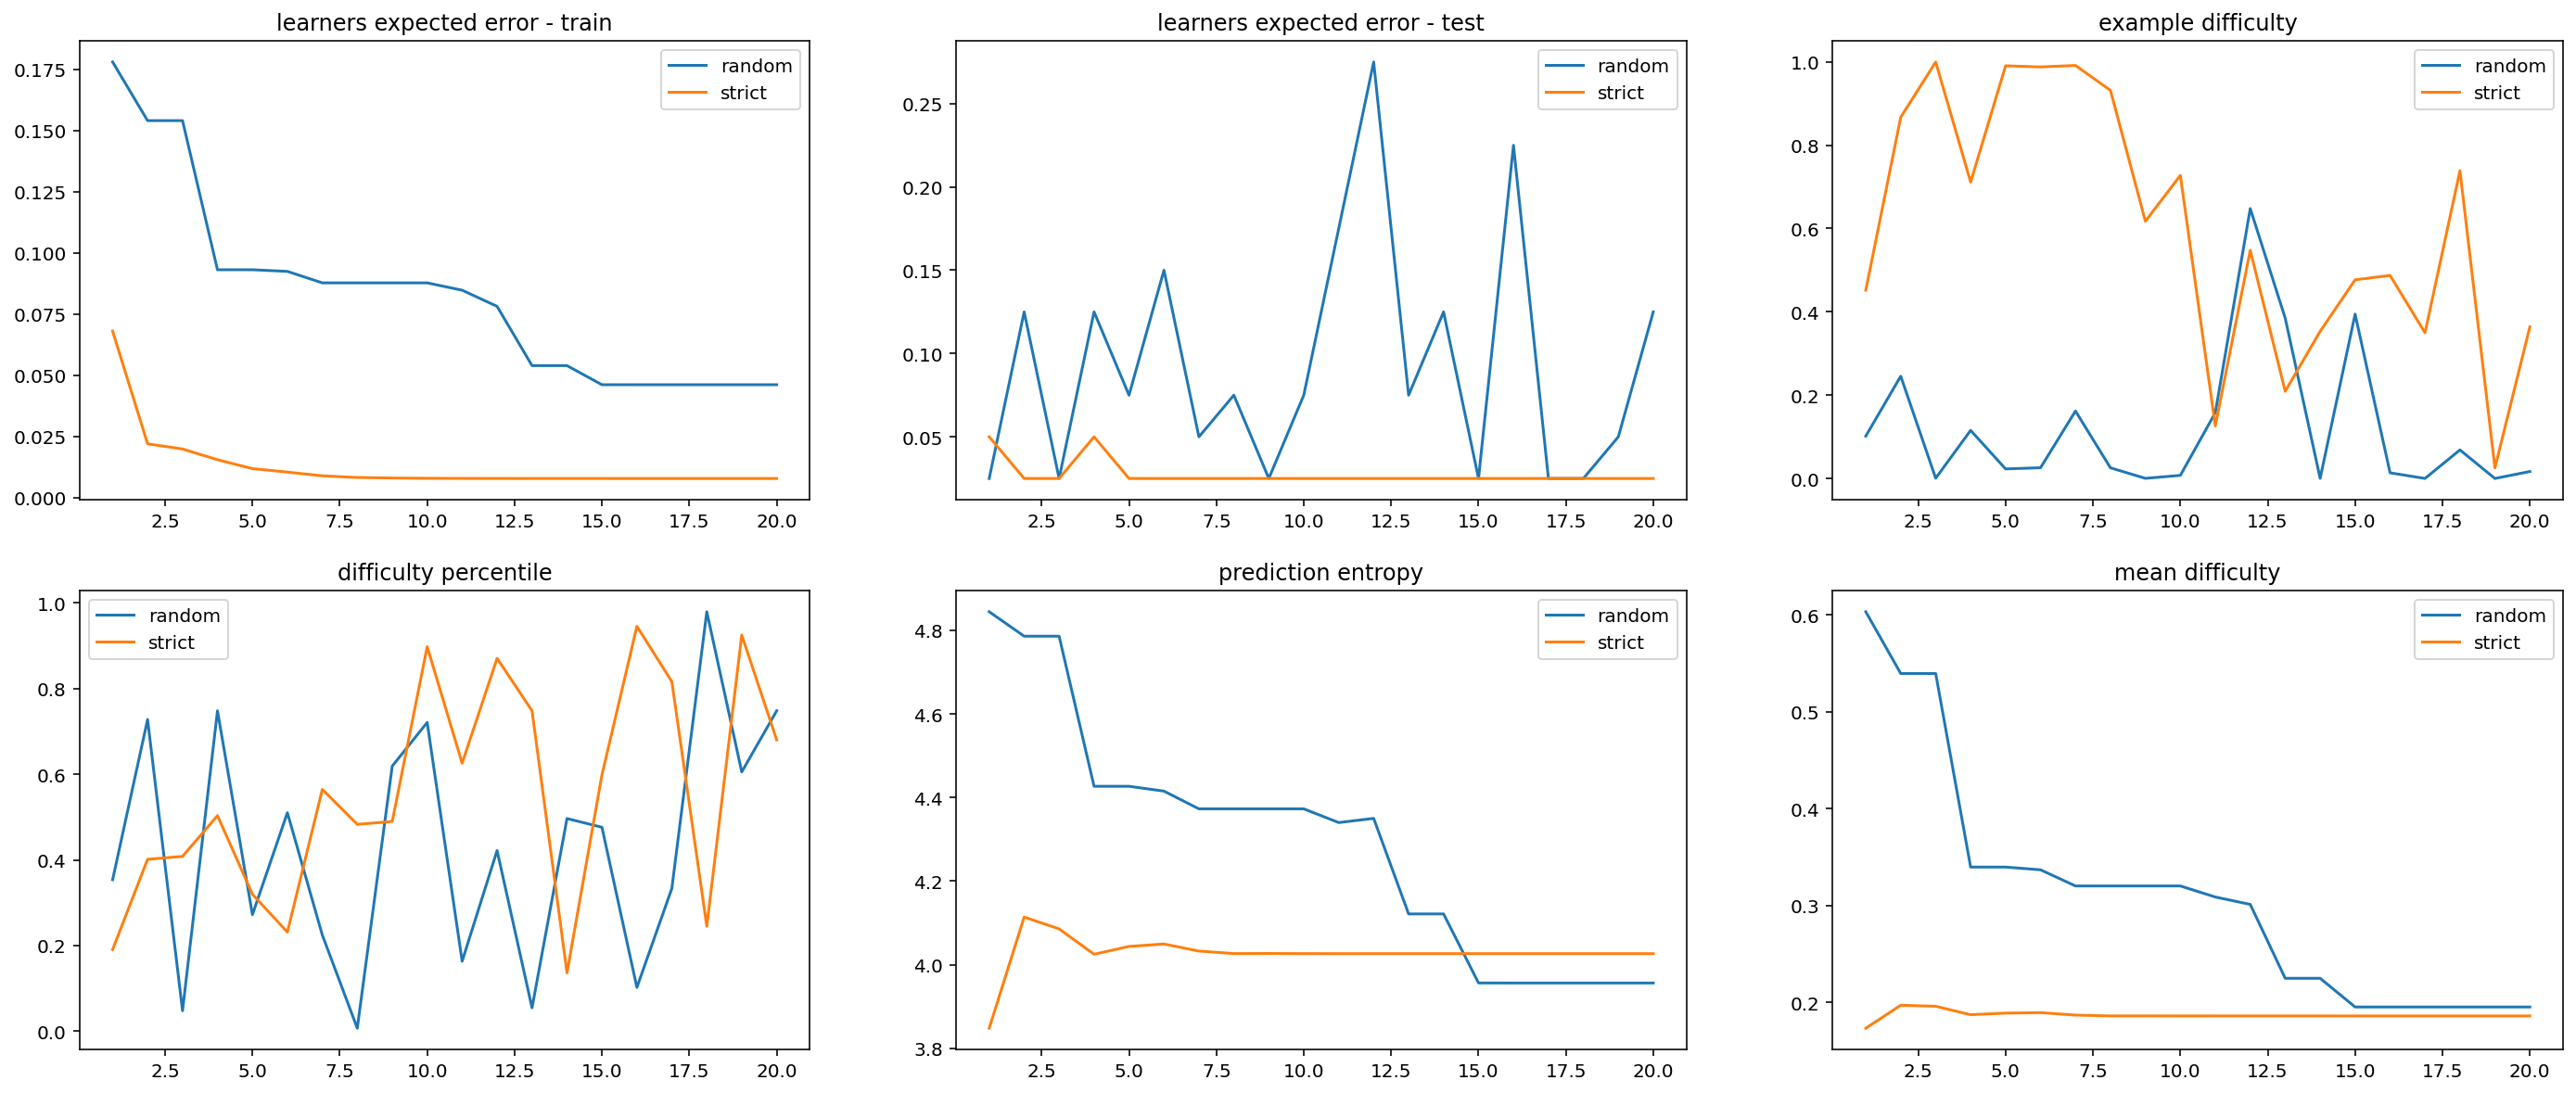

In [52]:
# plot in 2D
# fig_id = 0
# if (dataset_train['X'].shape[1] <= 3):
#     for alg_name in teachers.keys():
#         if one_v_all:
#             ut.plot_2D_data(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].lnr_post / teachers[alg_name].lnr_post.sum(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
#         else:
#             ut.plot_2D_data_hyper(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].lnr_post / teachers[alg_name].lnr_post.sum(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
#         fig_id += 1

fig, ax = plt.subplots(2, 3, figsize=(24, 10))

ax[0, 0].set_title('learners expected error - train')
for alg_name in teachers.keys():
    exp_err = teachers[alg_name].stats['exp_err']
    ax[0, 0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0, 0].legend()

ax[0, 1].set_title('learners expected error - test')
for alg_name in teachers.keys():
    exp_err_test = teachers[alg_name].stats['exp_err_test']
    ax[0, 1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[0, 1].legend()

ax[0, 2].set_title('example difficulty')
for alg_name in teachers.keys():
    difficulty = teachers[alg_name].stats['difficulty']
    ax[0, 2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[0, 2].legend()
fig.show()

ax[1, 0].set_title('difficulty percentile')
for alg_name in teachers.keys():
    diff_pctl = teachers[alg_name].stats['diff_pctl']
    ax[1, 0].plot(np.arange(len(diff_pctl))+1, diff_pctl, label=alg_name)
ax[1, 0].legend()
fig.show()

ax[1, 1].set_title('prediction entropy')
for alg_name in teachers.keys():
    pred_ent = teachers[alg_name].stats['pred_ent']
    ax[1, 1].plot(np.arange(len(pred_ent))+1, pred_ent, label=alg_name)
ax[1, 1].legend()
fig.show()

ax[1, 2].set_title('mean difficulty')
for alg_name in teachers.keys():
    diff_mean = teachers[alg_name].stats['diff_mean']
    ax[1, 2].plot(np.arange(len(diff_mean))+1, diff_mean, label=alg_name)
ax[1, 2].legend()
fig.show()

In [15]:
def run_trials(n, dataset, lnr_alphas):

    lnr_alpha = np.random.choice(lnr_alphas)

    dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
    one_v_all = False # binary

    random_teachers = []
    strict_teachers = []

    for i in range(n):

        # generate set of hypotheses
        hyps = np.array([z for z in zip(simple_hyps, -simple_hyps)])
        prior_h = np.ones(len(hyps)) / float(len(hyps))
        print(len(hyps), hyp_type, 'hypotheses\n')

        # remove examples that are inconsistent with best hypothesis
        err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
        dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

        # re compute hypothesis errors - after removing inconsistent examples
        err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
        err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], lnr_alpha)

        # teachers
        teachers = {}
        teachers['random'] = teach.RandomImageTeacher(dataset_train, lnr_alpha, prior_h, hyps)
        teachers['strict'] = teach.StrictTeacher(dataset_train, alpha, lnr_alpha, prior_h, hyps)

        # run teaching
        for alg_name in teachers.keys():
            print(alg_name)
            teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, hyps, err_hyp, err_hyp_test)
    
        random_teachers.append(teachers['random'])
        strict_teachers.append(teachers['strict'])

    return random_teachers, strict_teachers

In [24]:
import random
random.seed(42)
np.random.seed(42)

n = 10
rts, sts = run_trials(n, datasets, lnr_alphas)

96 k_octa hypotheses

13 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict
96 k_octa hypotheses

0 train examples removed
random
strict


In [25]:
ts = {}
ts['random'] = rts
ts['strict'] = sts

In [30]:
rts[0].lnr_alpha

4

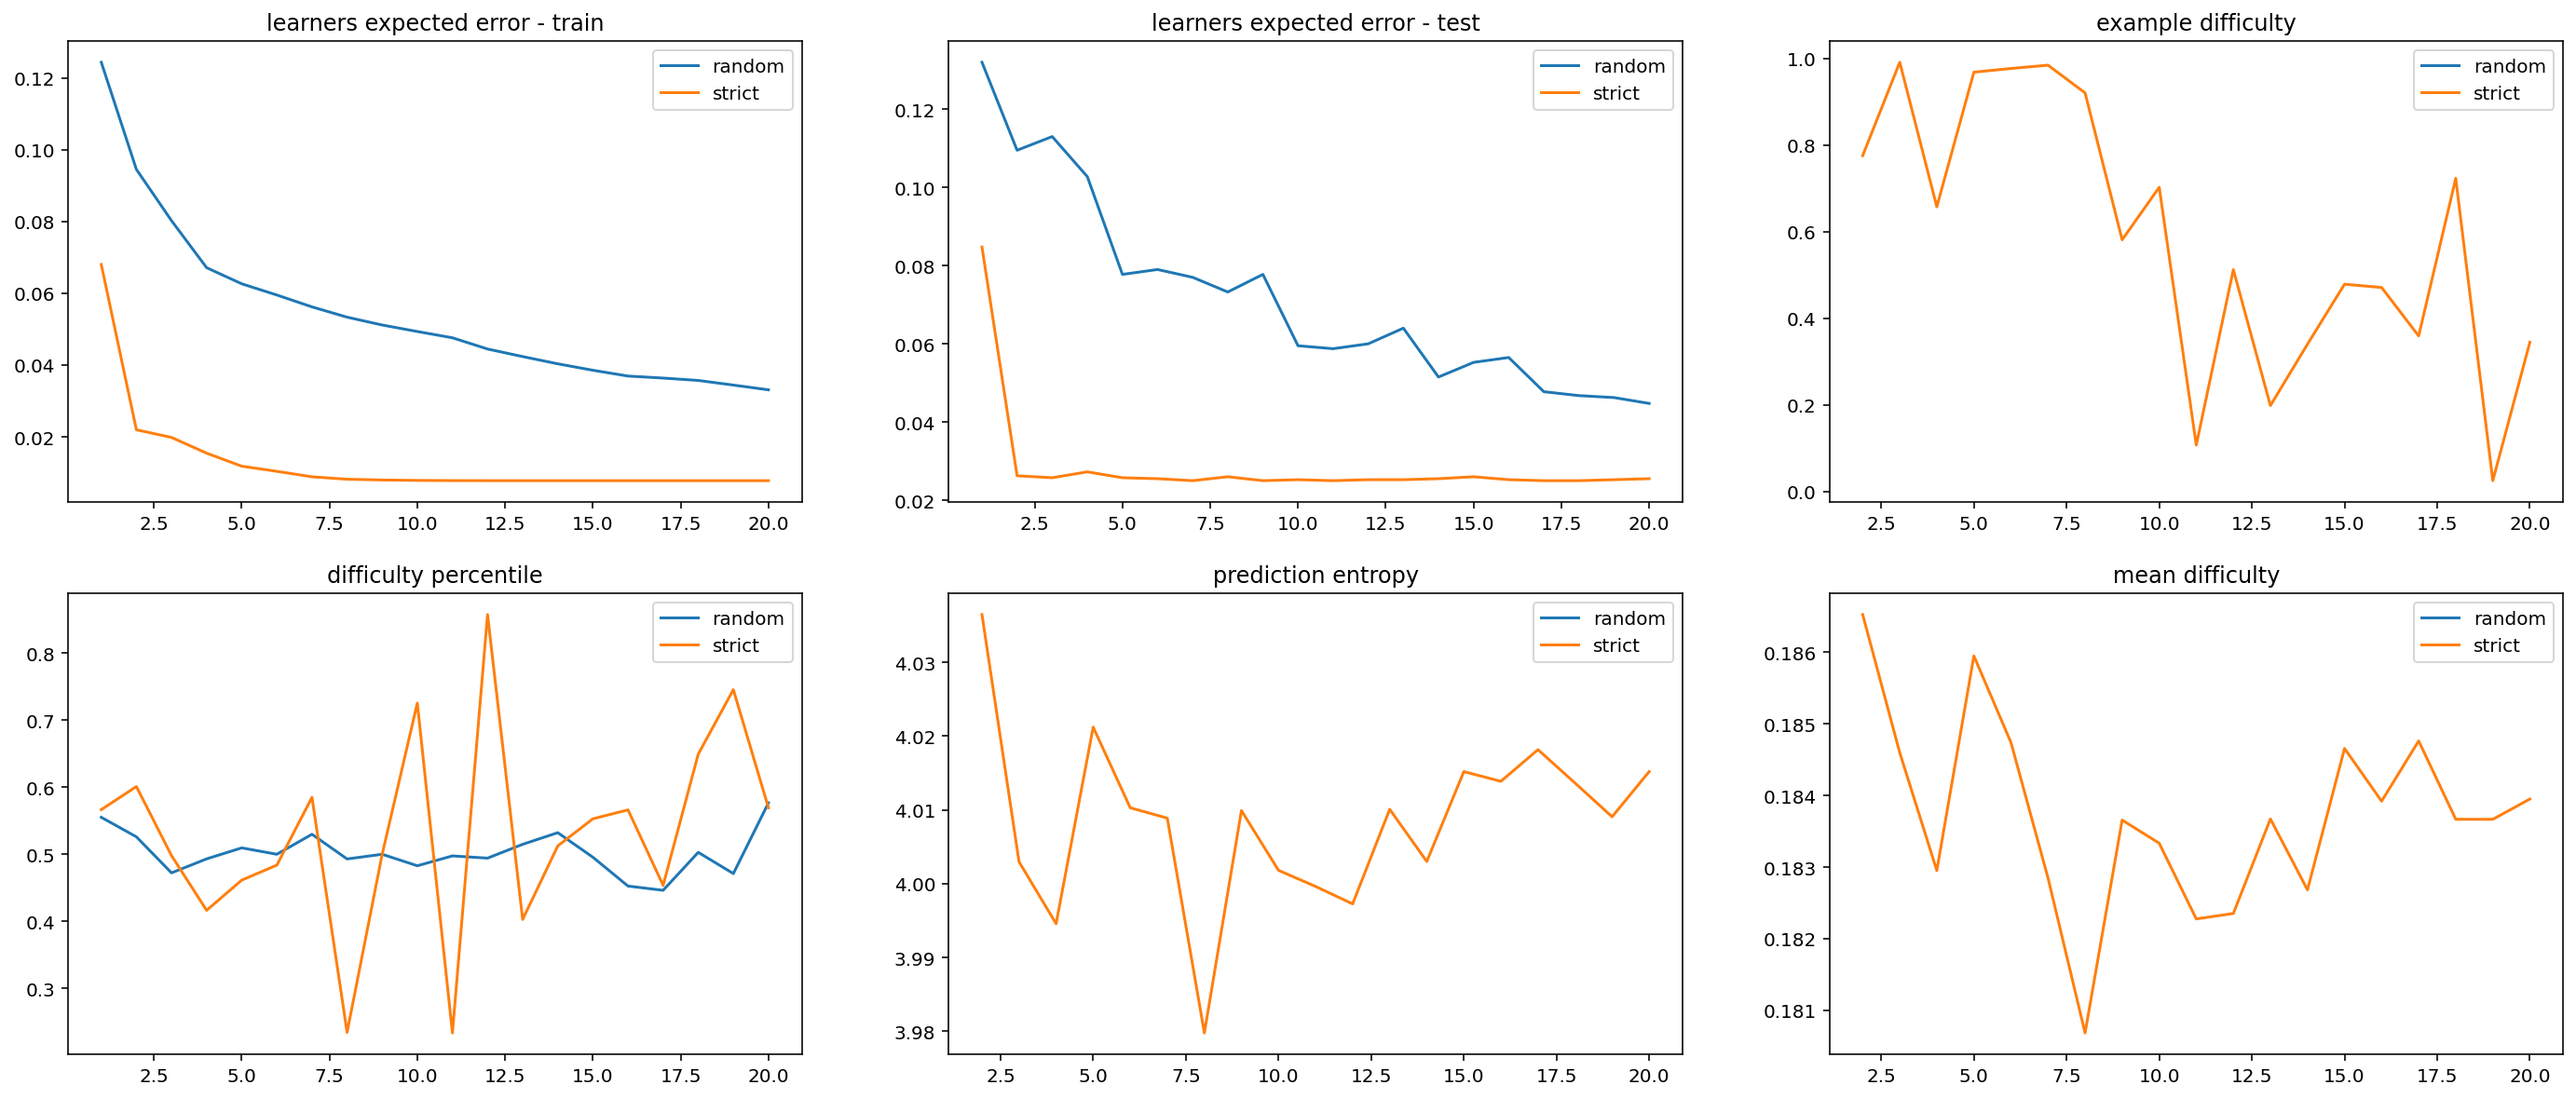

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))

ax[0, 0].set_title('learners expected error - train')
for alg_name in ts.keys():
    exp_err = np.array([t.stats['exp_err'] for t in ts[alg_name]]).mean(0)
    ax[0, 0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0, 0].legend()

ax[0, 1].set_title('learners expected error - test')
for alg_name in ts.keys():
    exp_err_test = np.array([t.stats['exp_err_test'] for t in ts[alg_name]]).mean(0)
    ax[0, 1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[0, 1].legend()

ax[0, 2].set_title('example difficulty')
for alg_name in ts.keys():
    difficulty = np.array([t.stats['difficulty'] for t in ts[alg_name]]).mean(0)
    ax[0, 2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[0, 2].legend()
fig.show()

ax[1, 0].set_title('difficulty percentile')
for alg_name in ts.keys():
    diff_pctl = np.array([t.stats['diff_pctl'] for t in ts[alg_name]]).mean(0)
    ax[1, 0].plot(np.arange(len(diff_pctl))+1, diff_pctl, label=alg_name)
ax[1, 0].legend()
fig.show()

ax[1, 1].set_title('prediction entropy')
for alg_name in ts.keys():
    pred_ent = np.array([t.stats['pred_ent'] for t in ts[alg_name]]).mean(0)
    ax[1, 1].plot(np.arange(len(pred_ent))+1, pred_ent, label=alg_name)
ax[1, 1].legend()
fig.show()

ax[1, 2].set_title('mean difficulty')
for alg_name in ts.keys():
    diff_mean = np.array([t.stats['diff_mean'] for t in ts[alg_name]]).mean(0)
    ax[1, 2].plot(np.arange(len(diff_mean))+1, diff_mean, label=alg_name)
ax[1, 2].legend()
fig.show()